https://www.chciken.com/digital/signal/processing/2020/05/13/guitar-tuner.html

https://gist.github.com/endolith/255291#L38

In [1]:
import pyaudio
import scipy.signal as signal
import scipy.fft
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.io.wavfile import read
from IPython.display import clear_output
from scipy import interpolate
from statistics import mode

%matplotlib notebook

ModuleNotFoundError: No module named 'pyaudio'

In [2]:
#reference: https://www.johndcook.com/blog/2016/02/10/musical-pitch-notation/

import math

A4 = 440
C0 = A4*pow(2, -4.75)
name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    
def pitch(freq):
    h = round(12*math.log2(freq/C0))
    octave = h // 12
    n = h % 12
    return name[n]

In [3]:
def fft(data, sampleRate):
    freq = scipy.fft.fft(data)
    freqs = scipy.fft.fftfreq(len(freq)) * sampleRate
    freq = freq[0:250]
    freqs = freqs[0:250]
    freq = np.abs(freq)
    return freqs, freq

In [4]:
# fixed chunk size
CHUNK = 1024 * 4
sampleRate = 44100

#initialize pyaudio
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=sampleRate, input=True, frames_per_buffer=CHUNK)

<IPython.core.display.Javascript object>


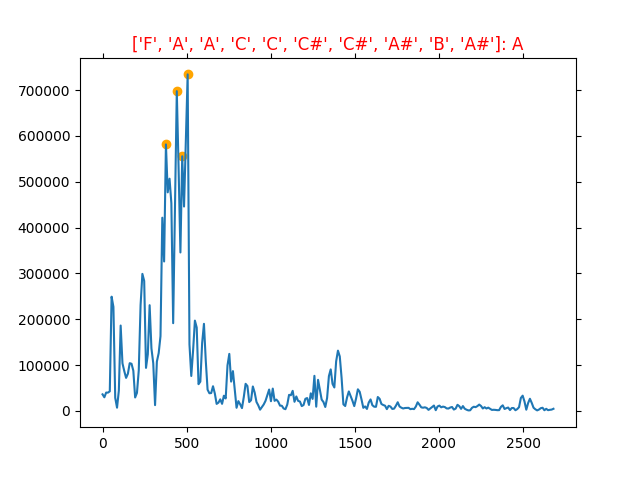

KeyboardInterrupt: 

In [5]:
#windowing
window = signal.windows.hamming(CHUNK, sym = False)

#live plotting setup
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

tot = []
dev = []
while(True):
    #data stream and filter
    data = stream.read(CHUNK)
    data = np.frombuffer(data, dtype=np.int16)
    data = data * window
    
    #compute fft
    freqs, freq = fft(data, sampleRate)
    
    #gives index of each peak
    peaks, _ = signal.find_peaks(freq)
    magPeaks = np.sort(freq[peaks])
    
    #select top n values
    n = 4
    magPeaks = magPeaks[-n:]
    locPeaks = []
    for val in magPeaks:
        locPeaks.append(freqs[np.where(freq == val)])
    locPeaks = np.sort(locPeaks)
    notes = []
    for val in locPeaks:
        notes.append(pitch(val))
    tot.append(mode(notes))
    tot = tot[-10:]
    #dev.append(np.std(freq))

    #live plotting
    ax.clear()
    if (np.std(freq) > 1e4):
        ax.set_title(str(tot) + ': ' + str(mode(tot)), color = 'red')
    else:
        ax.set_title(str(tot))
    ax.plot(freqs, freq)
    #ax.plot(dev)  
    ax.scatter(locPeaks, magPeaks, color = 'orange')
    fig.canvas.draw()

# close stream
stream.stop_stream()
stream.close()
p.terminate()